In [486]:
# Initialize notebook: imports and plot style config
%run init.py

Current time: 2020-04-10 19:08:04.996154


In [487]:
# source and format dataset
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
data = pd.read_csv(url)

# rename columns
data = data.rename(columns={
    'Date': 'date',
    'Country/Region': 'location',
    'Province/State': 'region',
    'Confirmed': 'cases',
    'Recovered': 'recovered',
    'Deaths': 'deaths',
})

# dates to datetime
data['date'] = data['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%d'))

# format region naming
def format_region(row):
    if row['region'] is np.nan:
        return row['location']
    else:
        return row['region']
data['region'] = data.apply(format_region, axis=1)



    
# add missing overall data for country
for country in data[data.region!=data.location].location.unique():
    if (country in data[data.location==country].region.unique())==False:
        df = data[data.location==country].groupby(['location', 'date'],as_index=False).sum()
        df['region'] = country
        data = data.append(df, ignore_index=True)
        
        

# dictionary of population
population = {
    'Hubei': 56e6,
    'Korea, South': 54.5e6,
    #'Japan': 127e6,
    #'Iran': 81e6,
    'Australia': 24.6e6,
    'US': 327e6,
    #'Switzerland': 8.5e6,
    #'Austria': 8.8e6,
    #'Germany': 82.7e6,
    #'France': 67e6,
    #'United Kingdom': 66.5e6,
    #'Spain': 46.6e6,
    #'San Marino': 33.7e3,
    #'Italy': 60e6,
    'Hong Kong': 7.392e6,
    'Canada': 37.59e6,
}
popdf = pd.read_csv('dataframes/world_population.csv')    
for state in data.region.unique():
    try: 
        data.at[data.region==state, 'population'] = popdf[popdf.location==state].population.iat[0]
    except:
        continue
for state in population.keys():
    if state not in list(popdf.location): 
        data.at[data.region==state, 'population'] = population[state]
data['population'] = data['population'].replace(np.nan, 9999999999)
data = data.replace(np.nan,0.0000000001)

# add differential columns
for col in ['cases', 'recovered', 'deaths']:
    data['new_'+col] = data[col].diff()

        
# relative increment (averaged over 1, 2, 3, 4 days)
for var in ['cases', 'deaths', 'recovered']: 
    for dayspan in [1,2,3,4]:
        colname = var+'_delta'+str(dayspan)
        data[colname] = 0
        for i in np.arange(dayspan):
            data[colname] = data[colname] + data['new_'+var].shift(i)/data[var].shift(i+1)
        data[colname] = data[colname]/dayspan
        #data[colname] = data[colname].map('{:.1e}'.format)

# add date per 100k inhabitants
for var in ['cases','new_cases','deaths','new_deaths','recovered','new_recovered']:
    data[var+'_per100k'] = data.apply(lambda row: row[var]/row.population*1e5, axis = 1)
    
# ordering and casting/formatting columns   
data = data[['date','region','cases','new_cases','deaths','new_deaths','recovered','new_recovered','population',
             'cases_per100k','new_cases_per100k','deaths_per100k','new_deaths_per100k','recovered_per100k','new_recovered_per100k',
             'cases_delta1','cases_delta2','cases_delta3','cases_delta4',
             'deaths_delta1','deaths_delta2','deaths_delta3','deaths_delta4',
             'recovered_delta1','recovered_delta2','recovered_delta3','recovered_delta4',
            ]]
data = data.replace(np.nan,0.0000000001)
data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population']] = data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population']].astype(int)

# last update time
lastday = pd.to_datetime(str(data.date.unique()[-1]))
print('\n Last updated data on:', lastday)

# print available countries
#print('\n Available Countries', data.region.unique())

data[(data.population>10e6)&(data.date==lastday)].sort_values('cases_per100k', ascending=False).head(20)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)



 Last updated data on: 2020-04-09 00:00:00


,date,region,cases,new_cases,deaths,new_deaths,recovered,new_recovered,population,cases_per100k,new_cases_per100k,deaths_per100k,new_deaths_per100k,recovered_per100k,new_recovered_per100k,cases_delta1,cases_delta2,cases_delta3,cases_delta4,deaths_delta1,deaths_delta2,deaths_delta3,deaths_delta4,recovered_delta1,recovered_delta2,recovered_delta3,recovered_delta4
17853,2020-04-09,Spain,153222,5002,15447,655,52165,4144,46754783,327.7,10.7,33.0,1.4,111.6,8.9,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1
11849,2020-04-09,Italy,143626,4204,18279,610,28470,1979,60461828,237.5,7.0,30.2,1.0,47.1,3.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1
1895,2020-04-09,Belgium,24983,1580,2523,283,5164,483,11589616,215.6,13.6,21.8,2.4,44.6,4.2,0.1,0.1,0.1,0.1,0.1,0.1,0.2,0.2,0.1,0.1,0.1,0.1
9242,2020-04-09,France,117749,4799,12210,1341,23206,1952,65273512,180.4,7.4,18.7,2.1,35.6,3.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
19038,2020-04-09,US,461437,32385,16478,1783,25410,1851,327000000,141.1,9.9,5.0,0.5,7.8,0.6,0.1,0.1,0.1,0.1,0.1,0.1,0.2,0.1,0.1,0.1,0.1,0.1
10348,2020-04-09,Germany,118181,4885,2607,258,52407,6107,83783945,141.1,5.8,3.1,0.3,62.6,7.3,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.2,0.2,0.2
16194,2020-04-09,Portugal,13956,815,409,29,205,9,10196707,136.9,8.0,4.0,0.3,2.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.1,0.1,0.3
14693,2020-04-09,Netherlands,21762,1213,2396,148,250,0,17134873,127.0,7.1,14.0,0.9,1.5,0.0,0.1,0.1,0.0,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0
5608,2020-04-09,Hubei,67803,0,3215,2,64187,45,56000000,121.1,0.0,5.7,0.0,114.6,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19354,2020-04-09,United Kingdom,65077,4344,7978,881,135,0,67886004,95.9,6.4,11.8,1.3,0.2,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0


In [488]:
# dictionary of lockdown dates
lockdown = {
    'Italy': datetime.date(2020,3,11),
    'Hubei': datetime.date(2020,1,25),
    'Iran': datetime.date(2020,3,15),
    'Spain': datetime.date(2020,3,14),
    'United Kingdom': datetime.date(2020,3,25),
    'Austria': datetime.date(2020,3,16),
}

# dictionary of colors
color = {
    'Hubei': 'r',
    'Korea, South': 'purple',
    'Japan': 'grey',
    'Iran': 'limegreen',
    'Australia': 'royalblue',
    'US': 'hotpink',
    'Switzerland': 'brown',
    'Austria': 'pink',
    'Germany': 'black',
    'France': 'blue',
    'United Kingdom': 'g',
    'Spain': 'orange',
    #'San Marino': 'paleturquoise',
    'Italy': 'dodgerblue',
    #'Hong Kong': 'magenta'
}

In [489]:
# Utility functions

def rate(df, var, dayspan=3):
    k=[]
    for i in np.arange(dayspan):
        k.append(df['new_'+var].iat[-1-i]/df[var].iat[-1-i])
    return np.mean(k)*100

def format_dateaxis():
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()

def lockdown_lines():
    for state in lockdown.keys():
        ax.vlines(lockdown[state],-1000,1000, color=color[state], linestyle='--', linewidth=2, alpha=0.75)

def sorted_states(states, var):
    df = data[data.region.isin(states)][data.date==lastday].sort_values(var, ascending=False)
    states = df.region.unique()
    return states

def leglabels_style():
    leg._legend_box.align = "left"
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())

def plot_total(var,lw=3):
    #cmap = plt.get_cmap('tab20')
    for state in states:
        df = data[data.region==state]
        pop = df.population.iat[0]
        tot = df[var].iat[-1] # total value at current date
        new = df['new_'+var].iat[-1]
        k = rate(df, var)
        label = state + '\nTotal: %.f (+%.f)\n1 over %.f\nDaily increase: +%.1f%s' % (tot, new, pop/tot, k, '%')
        if var=='deaths': 
            mortality = tot/df['cases'].iat[-1]*100
            label = label + '\nMortality: %.1f%s' % (mortality, '%')
        ax.plot(df.date, df[var]/pop*1e5, label=label, color=color[state], lw=lw)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


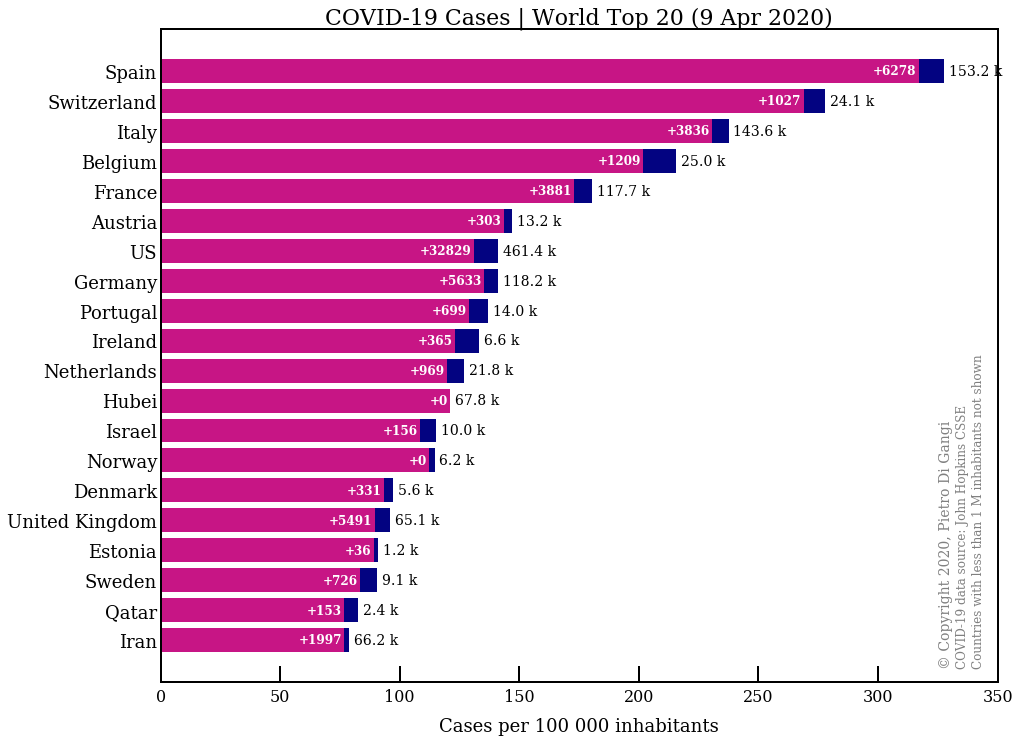

In [490]:
def standing_normalized(states, var, title='', xlabel='x', xmax=100):

    n = len(states)*0.1
    
    fig = plt.figure(figsize=(15,6*n))
    ax = fig.add_subplot(111)
    ax.tick_params(left=False) 
    states = sorted_states(states, var+'_per100k')
    states = states[::-1]
    
    for i,state in enumerate(states):
        df = data[data.region==state]
        pop = data.population.iat[0]
        tot = df[var].iat[-1]
        ax.barh(state, df[var+'_per100k'].iat[-1], color='navy', label='', alpha=0.99)
        for days in np.arange(1):
            ax.barh(state, df[var+'_per100k'].iat[-2-days], color='mediumvioletred', label='', alpha=1)
        lb = '%.1f k' % (tot/1000)
        ax.text(df[var+'_per100k'].iat[-1]+2, state, lb, ha='left', va='center', fontsize=14)
        ax.text(df[var+'_per100k'].iat[-2]-1, state, ('+%d' % df['new_'+var].iat[-2]), ha='right', va='center', color='w', fontsize=12, weight='bold')
    
    plt.xlabel(xlabel)
    #ax.grid(axis='x', linewidth=2, alpha=0.1, which='major')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.set_xlim(0,xmax)
    
    #legend
    plt.title(title+' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=22)
    
    # disclaimer
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(xmax-0.07*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14)
    text = 'COVID-19 data source: John Hopkins CSSE'
    plt.text(xmax-0.05*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)
    text = 'Countries with less than 1 M inhabitants not shown'
    plt.text(xmax-0.03*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12)

    plt.show()
    
    #fig.savefig('figure/%s-covid19-sicilia-contagi-normalizzati.png' % lastday.strftime('%Y-%m-%d'))
       
    
states = data[(data.population>1e6)&(data.date==lastday)].sort_values('cases_per100k', ascending=False).head(20).region.unique()
standing_normalized(states, 'cases', 'COVID-19 Cases | World Top 20', 'Cases per 100 000 inhabitants', xmax=350)

#states = data[(data.population>1e6)&(data.date==lastday)].sort_values('deaths_per100k', ascending=False).head(20).region.unique()
#standing_normalized(states, 'deaths', 'COVID-19 Deaths | World Top 20', 'Deaths per 100 000 inhabitants', xmax=40)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


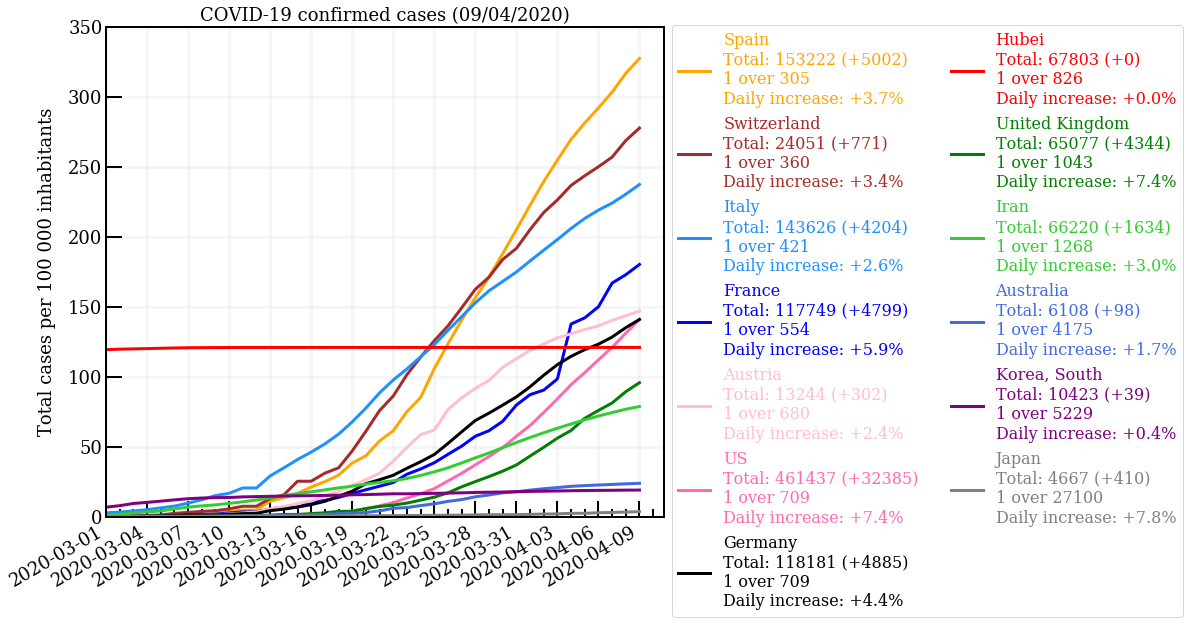

In [491]:
var = 'cases' # selected variable
states = color.keys() # selected states

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, var+'_per100k')

# plot curves
plot_total(var)

# axes
format_dateaxis()
ax.set_xlim([datetime.datetime(2020, 3, 1), today+timedelta(days=0)])
ax.set_ylim(0,350)
plt.ylabel('Total ' + var + ' per 100 000 inhabitants')
#plt.yscale('log')
plt.grid(axis='both', linewidth=3, alpha=0.1, which='major')

#legend
leg = plt.legend(loc='upper left', ncol=2, fontsize=16, bbox_to_anchor=(1,1.02)) 
plt.title('COVID-19 confirmed cases (%s)' % lastday.strftime('%d/%m/%Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


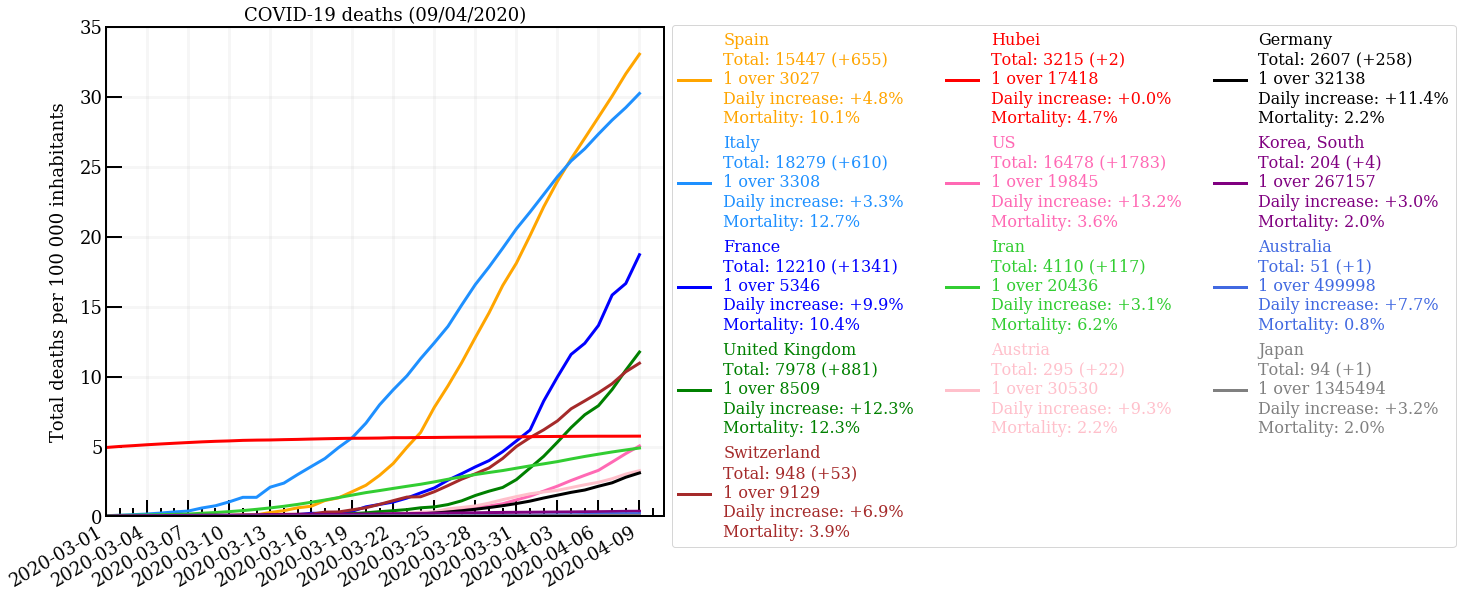

In [492]:
var = 'deaths'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, var+'_per100k')

# plot curves
plot_total(var)

# axes
format_dateaxis()
ax.set_xlim([datetime.datetime(2020, 3, 1), today+timedelta(days=0)])
ax.set_ylim(1e-2,35)
plt.ylabel('Total ' + var + ' per 100 000 inhabitants')
#plt.yscale('log')
plt.grid(axis='both', linewidth=3, alpha=0.1, which='major')

#legend
leg = plt.legend(loc='upper left', ncol=3, fontsize=16, bbox_to_anchor=(1,1.02))
plt.title('COVID-19 deaths (%s)' % lastday.strftime('%d/%m/%Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


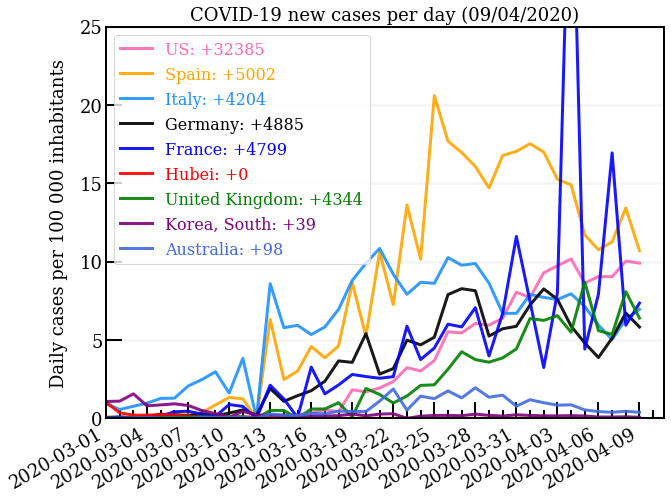

In [493]:
var = 'new_cases'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South', 'Australia']
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, 'cases')

# plot curves
for state in states:
    df = data[data.region==state]
    pop = df.population.iat[0]
    tot = df[var].iat[-1] # total value at current date
    label = state + ': +%.f' % tot
    ax.plot(df.date, df[var]/pop*1e5, label=label, color=color[state], lw=3, alpha=0.9)

# axes
format_dateaxis()
ax.set_xlim([datetime.datetime(2020, 1, 22), today+timedelta(days=0)])
ax.set_ylim(0,25)
ax.set_xlim(left=datetime.date(2020,3,1))
plt.ylabel('Daily cases per 100 000 inhabitants')
#plt.yscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc='upper left', frameon=True, ncol=1, fontsize=16)
plt.title('COVID-19 new cases per day (%s)' % lastday.strftime('%d/%m/%Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


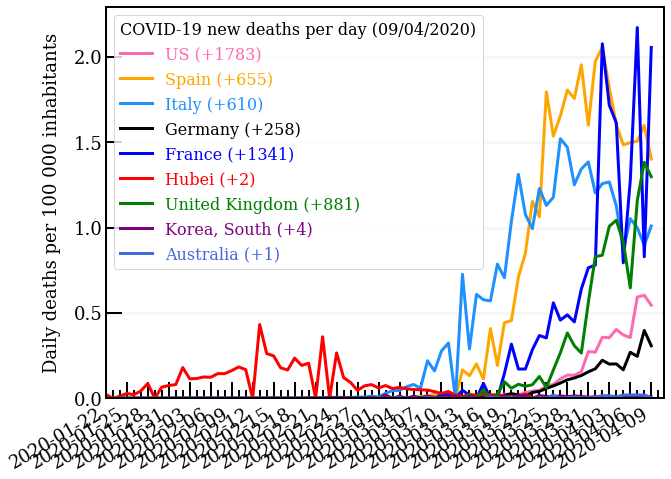

In [494]:
var = 'new_deaths'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South', 'Australia']
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, 'cases')

# plot curves
for state in states:
    df = data[data.region==state]
    pop = df.population.iat[0]
    tot = df[var].iat[-1] # total value at current date
    label = state + ' (+%.f)' % tot
    ax.plot(df.date, df[var]/pop*1e5, label=label, color=color[state], lw=3)

# axes
format_dateaxis()
ax.set_xlim([datetime.datetime(2020, 1, 22), today+timedelta(days=0)])
ax.set_ylim(bottom=0)
plt.ylabel('Daily deaths per 100 000 inhabitants')
#plt.yscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc='upper left', frameon=True, ncol=1, fontsize=16, title_fontsize=16, 
                 title='COVID-19 new deaths per day (%s)' % lastday.strftime('%d/%m/%Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


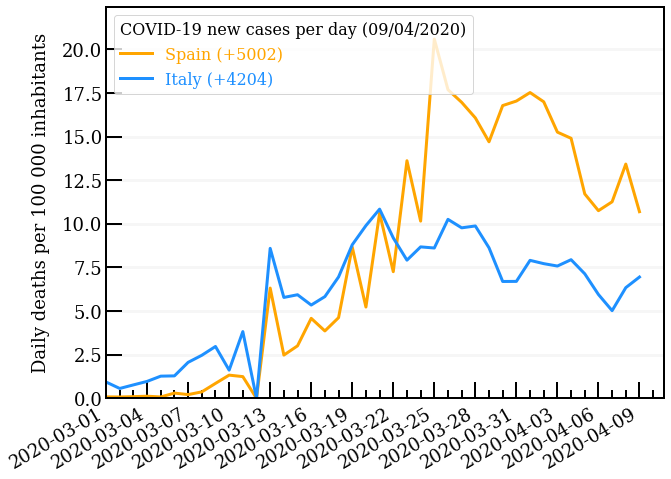

In [495]:
var = 'new_cases'
states = ['Italy', 'Spain']
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, 'cases')

# plot curves
for state in states:
    df = data[data.region==state]
    pop = df.population.iat[0]
    tot = df[var].iat[-1] # total value at current date
    label = state + ' (+%.f)' % tot
    ax.plot(df.date, df[var]/pop*1e5, label=label, color=color[state], lw=3)

# axes
format_dateaxis()
ax.set_xlim([datetime.datetime(2020, 3, 1), today+timedelta(days=0)])
ax.set_ylim(bottom=0)
plt.ylabel('Daily deaths per 100 000 inhabitants')
#plt.yscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc='upper left', frameon=True, ncol=1, fontsize=16, title_fontsize=16, 
                 title='COVID-19 new cases per day (%s)' % lastday.strftime('%d/%m/%Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


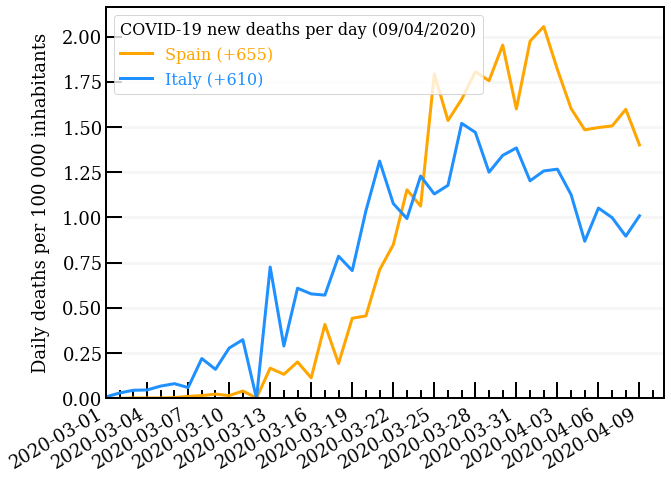

In [496]:
var = 'new_deaths'
states = ['Italy', 'Spain']
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, 'cases')

# plot curves
for state in states:
    df = data[data.region==state]
    pop = df.population.iat[0]
    tot = df[var].iat[-1] # total value at current date
    label = state + ' (+%.f)' % tot
    ax.plot(df.date, df[var]/pop*1e5, label=label, color=color[state], lw=3)

# axes
format_dateaxis()
ax.set_xlim([datetime.datetime(2020, 3, 1), today+timedelta(days=0)])
ax.set_ylim(bottom=0)
plt.ylabel('Daily deaths per 100 000 inhabitants')
#plt.yscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc='upper left', frameon=True, ncol=1, fontsize=16, title_fontsize=16, 
                 title='COVID-19 new deaths per day (%s)' % lastday.strftime('%d/%m/%Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


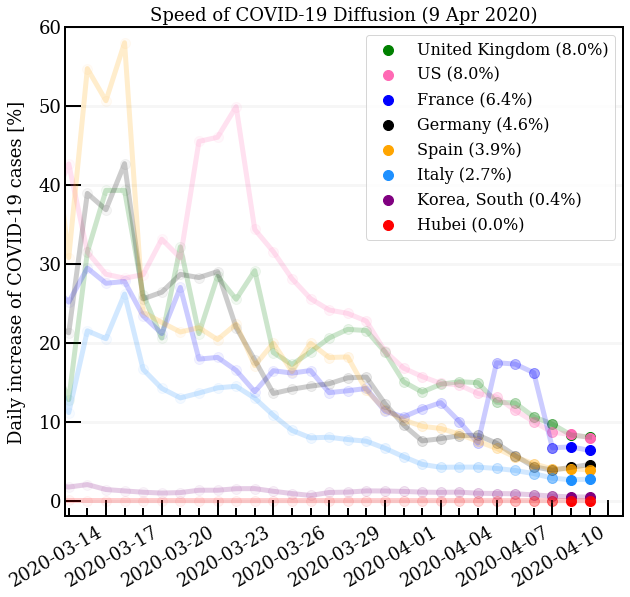

In [497]:
var = 'cases_delta3'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, var)

# plot curves
for state in states:
    df = data[data.region==state]    
    ax.plot(df.date, df[var]*100, label='', color=color[state], lw=5, alpha=0.2)

ndays = 30
days = np.arange(1,ndays) 
mk='o'
ms=100
for state in states:
    df = data[data.region==state]
    tot = df[var].iat[-1]*100 # total value at current date
    pop = df.population.iat[0]
    label = state + ' (%.1f%s)' % (tot,'%')
    ax.scatter(df.date.iat[-1], df[var].iat[-1]*100, label=label, color=color[state], marker=mk, s=ms)
    for day in list(reversed(days)):
        x = df['date'].iat[-1-day] # total value 'day' ago
        y = df[var].iat[-1-day]*100
        alpha = 1/day
        ax.scatter(x,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)

# axes
format_dateaxis()
ax.set_xlim([today-timedelta(days=ndays), today+timedelta(days=0)])
ax.set_ylim(-2,60)
plt.ylabel('Daily increase of COVID-19 cases [%]')
#plt.xscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc=0, frameon=True)
plt.title('Speed of COVID-19 Diffusion (%s)' % lastday.strftime('%-d %b %Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


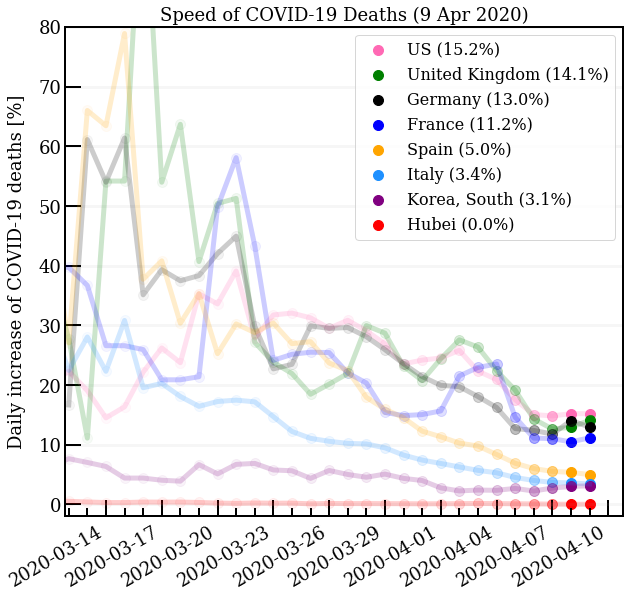

In [498]:
var = 'deaths_delta3'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, var)

# plot curves
for state in states:
    df = data[data.region==state]    
    ax.plot(df.date, df[var]*100, label='', color=color[state], lw=5, alpha=0.2)

ndays = 30
days = np.arange(1,ndays) 
mk='o'
ms=100
for state in states:
    df = data[data.region==state]
    tot = df[var].iat[-1]*100 # total value at current date
    df.population.iat[0]
    label = state + ' (%.1f%s)' % (tot,'%')
    ax.scatter(df.date.iat[-1], df[var].iat[-1]*100, label=label, color=color[state], marker=mk, s=ms)
    for day in list(reversed(days)):
        x = df['date'].iat[-1-day] # total value 'day' ago
        y = df[var].iat[-1-day]*100
        alpha = 1/day
        ax.scatter(x,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)

# axes
format_dateaxis()
ax.set_xlim([today-timedelta(days=ndays), today+timedelta(days=0)])
ax.set_ylim(-2,80)
plt.ylabel('Daily increase of COVID-19 deaths [%]')
#plt.xscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc=0, frameon=True)
plt.title('Speed of COVID-19 Deaths (%s)' % lastday.strftime('%-d %b %Y'))
leglabels_style()

plt.show()

In [499]:
def guideline(ax, xlim=(0,1), ylim=(0,1), m=1, label=''):
    xmin = xlim[0]
    xmax = xlim[1]
    ymin = ylim[0]
    ymax = ylim[1]
    ax.plot((0,xmax), (0,m*xmax), ls='--', lw=1, color='silver', zorder=-100)

    mplot = (ymax-ymin)/(xmax-xmin)
    if m < mplot:
        coord = [0.85*xmax, 0.85*xmax*m]
    else:
        coord = [0.85*ymax/m, 0.85*ymax]
    label = '%.f%s ' % (m*100, '%') + label
    ax.text(coord[0], coord[1], label, color='silver', fontsize=12, rotation=np.rad2deg(np.arctan(m/mplot)), ha='center', va='center', backgroundcolor='w', zorder=-100)

def trailplot(regions, ndays, varx, vary, xlabel, ylabel, xlim, ylim, guidelines, gl_label):
    #sorted_df = data[data.region.isin(regions)][data.date==lastday].sort_values(varx)
    #regions = sorted_df.region.unique()

    # Set up the axes with gridspec
    fig = plt.figure(figsize=(14,14))
    grid = plt.GridSpec(4, 4, hspace=0., wspace=0.)
    ax = fig.add_subplot(grid[:-1, 1:])
    y_ax = fig.add_subplot(grid[:-1, 0], xticks=[], sharey=ax)
    x_ax = fig.add_subplot(grid[-1, 1:], sharex=ax)
    x_ax.tick_params(axis='y', which='major', labelsize=14)
    ax.tick_params(labelbottom=False, labelleft=False)

    # axes
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    y_ax.set_ylabel(ylabel+' per 100 000 inhabitants')
    x_ax.set_xlabel(xlabel+' per 100 000 inhabitants')

    # mortality guidelines
    for m in guidelines:
        guideline(ax=ax, xlim=xlim, ylim=ylim, m=m, label=gl_label)

    # plot curves
    days = np.arange(1,ndays)
    mk = 'o'
    ms=200
    #dummy points
    #x_ax.scatter(0,'',label='', color='w', marker=mk, s=ms)
    y_ax.scatter('',0,label='', color='w', marker=mk, s=ms)

    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        pop = df['population'].iat[0]
        #ax.scatter(df[varx].iat[-1]/pop*1e5, df[vary].iat[-1]/pop*1e5, label='', color=color, marker=mk, s=ms)
        #x_ax.scatter(x,state,label='', color=color, marker=mk, s=ms, alpha=alpha)
        #y_ax.scatter(state,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
        for day in list(reversed(days)):
            x = df[varx].iat[-day]/pop*1e5 # total value 'day' ago
            y = df[vary].iat[-day]/pop*1e5
            alpha = 1./day
            ax.scatter(x,y,label='', color=color[reg], marker=mk, s=ms, alpha=alpha)
            x_ax.scatter(x,reg,label='', color=color[reg], marker=mk, s=ms, alpha=alpha)
            y_ax.scatter(reg,y,label='', color=color[reg], marker=mk, s=ms, alpha=alpha)
        #x_ax.text(x+0.03*xlim[1], reg, '%d (+%d)' % (df[varx].iat[-1], df['new_'+varx].iat[-1]), ha='left', va='center', fontsize=11)
        #y_ax.text(reg, y+0.03*ylim[1], '%d (+%d)' % (df[vary].iat[-1], df['new_'+vary].iat[-1]), ha='center', va='bottom', fontsize=11, rotation=90)

    #ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    #x_ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    #ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    #y_ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')

    #legend
    #leg = ax.legend(loc=0, frameon=True, ncol=1, 
    ax.set_title('COVID-19 | Last %d days (Updated %s)' % (ndays, lastday.strftime('%-d %b %Y')))
    #leglabels_style()

    plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


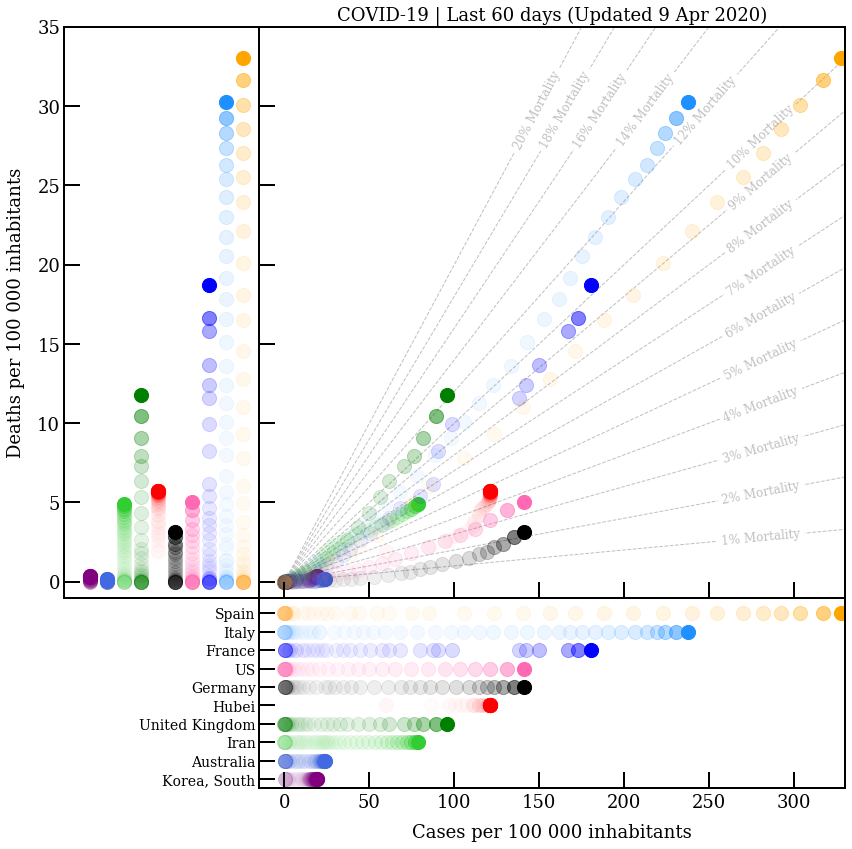

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


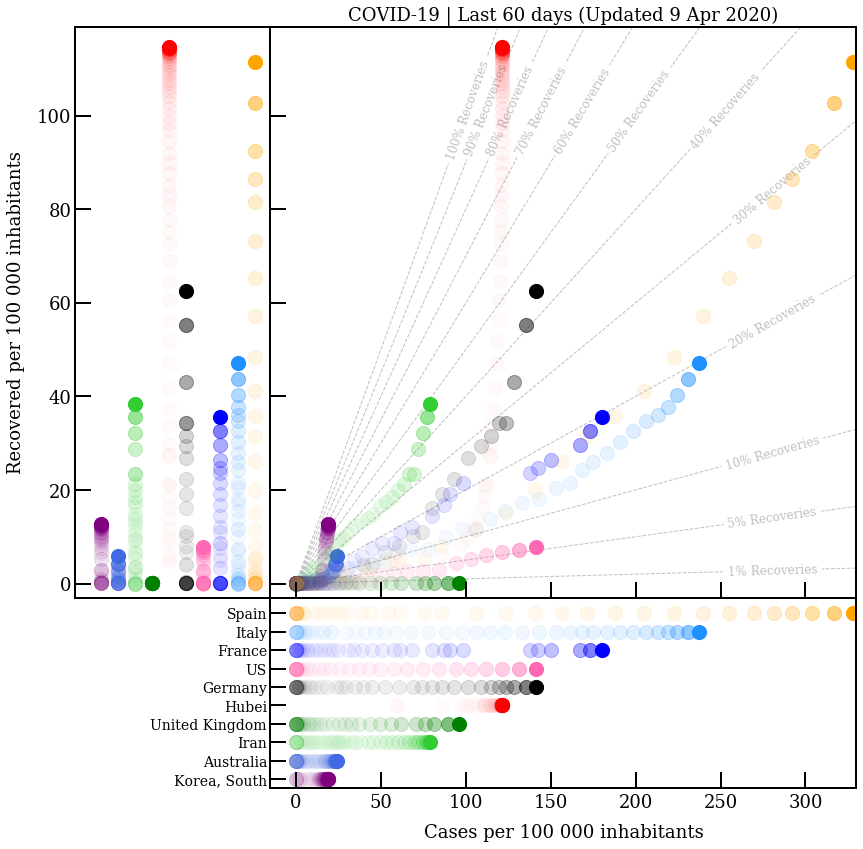

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


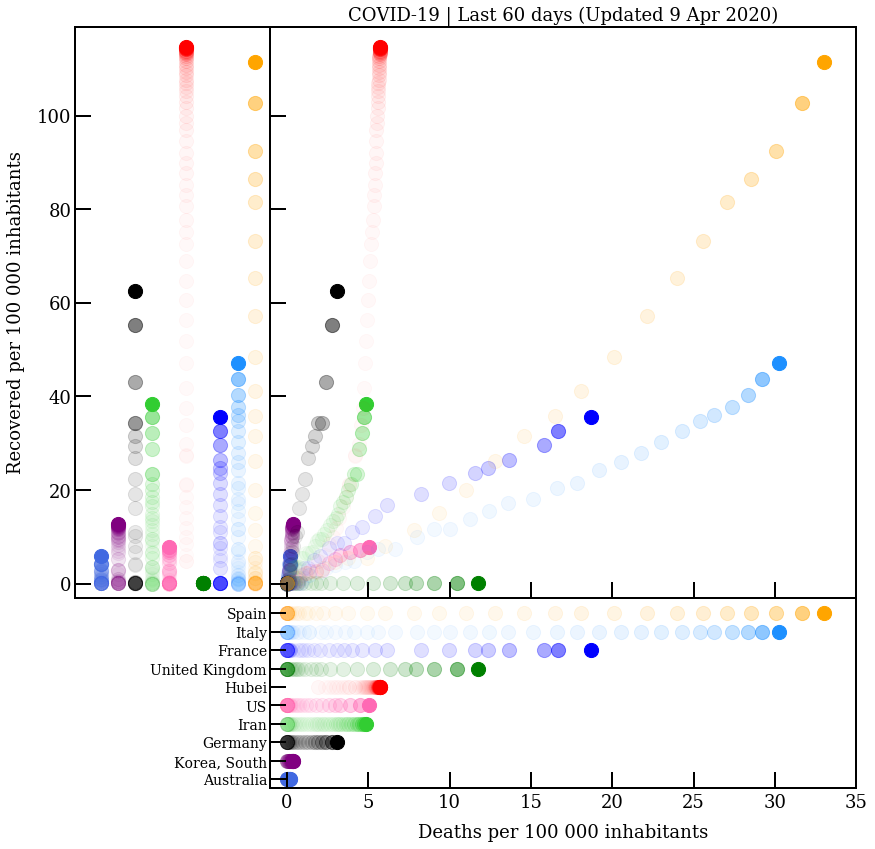

In [500]:
# Cases vs Deaths
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South', 'Australia', 'Iran']
states = data[data.region.isin(states)][data.date==lastday].sort_values('cases_per100k').region.unique()
#print(states)
trailplot(regions=states, ndays=60,
          varx='cases', vary='deaths', xlabel='Cases', ylabel='Deaths',
          xlim=(-15,330), ylim=(-1,35), guidelines=[0.2,0.18,0.16,0.14,0.12,0.1,0.09,0.08,0.07,0.06,0.05,0.03,0.04,0.02,0.01], gl_label='Mortality',
         )

# Cases vs Recovered
states = data[data.region.isin(states)][data.date==lastday].sort_values('cases_per100k').region.unique()
trailplot(regions=states, ndays=60,
          varx='cases', vary='recovered', xlabel='Cases', ylabel='Recovered',
          xlim=(-15,330), ylim=(-3,119), guidelines=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01,], gl_label='Recoveries',
         )

# Deaths vs Recovered
states = data[data.region.isin(states)][data.date==lastday].sort_values('deaths_per100k').region.unique()
trailplot(regions=states, ndays=60,
          varx='deaths', vary='recovered', xlabel='Deaths', ylabel='Recovered',
          xlim=(-1,35), ylim=(-3,119), guidelines=[], gl_label='',
         )